In [8]:
def filter_bldg_type_district(bldgs, gklas, municipalities):
    bldg_res = bldgs.loc[((bldgs["GKLAS"]== gklas) & (bldgs["GSTAT"]== 1004) & bldgs["GDENAME"].isin(municipalities))]
    return bldg_res

In [9]:
def get_PV_pot_bldgid(building_id):
    TOT_DATA = pd.DataFrame()
    url = 'https://api3.geo.admin.ch//rest/services/api/MapServer/find?'
    params = dict(
        layer='ch.bfe.solarenergie-eignung-daecher',
        searchField='building_id',
        searchText= building_id,
        contains='false'
    )

    # Fetch data using requests
    res = requests.get(url, params=params) 
    temp = json.loads(res.text)
    temp_3 = pd.DataFrame.from_dict(temp, orient="index")
    for i in range(len(temp_3.T)):
        POT_bldg_PV_data =  pd.DataFrame.from_dict(temp_3.iat[0,i],orient="index")
        POT_attributes = POT_bldg_PV_data.loc["attributes"].to_dict()
        POT_attr = pd.DataFrame.from_dict(POT_attributes).T
        
        POT_attr = POT_attr[['building_id', 'bedarf_heizung', 'bedarf_warmwasser', 'dg_heizung', 'dg_waermebedarf', 'flaeche_kollektoren', 'volumen_speicher', 'waermeertrag','klasse', 'flaeche', 'ausrichtung', 'stromertrag',  'df_nummer','neigung', 'label']]
        
        POT_attr = POT_attr.rename(columns ={'building_id':'building_id', 'bedarf_heizung':'demand_heating', 'bedarf_warmwasser':'demand_hot_water','dg_heizung':'percent_of_heating', 'dg_waermebedarf':'percent_of_thermaldemand',
                                             'flaeche_kollektoren':'area_collectors', 'volumen_speicher':'volume_storage', 'waermeertrag':'heat_output', 'klasse':'class', 'flaeche':'area', 'ausrichtung':'alignment', 
                                             'stromertrag':'electricity_yield',  'df_nummer':'df_nummer','neigung': 'inclination', 'label':'label'})
        
        POT_attr = POT_attr.set_index('label')
        TOT_DATA = pd.concat([TOT_DATA, POT_attr])
    
    return TOT_DATA

In [10]:
def get_PV_pot_coords(coords):
    url = 'https://api3.geo.admin.ch/rest/services/api/MapServer/identify?'
    params = dict(
        lang= "en",
        sr='2056',
        geometryType='esriGeometryPoint',
        geometry=coords,
        imageDisplay='0,0,0',
        mapExtent='0,0,0,0',
        tolerance='0',
        limit=10,
        returnGeometry ="false",
        layers='all:ch.bfe.solarenergie-eignung-daecher'

    )

    # Fetch data using requests
    res = requests.get(url, params=params) 
    temp = json.loads(res.text)
    temp_2 = pd.DataFrame.from_dict(temp, orient="columns")
    temp_2.reset_index()
    bldg_PV_data =  pd.DataFrame.from_dict(temp_2.iat[0,0],orient="index")
    bldg_PV_data = bldg_PV_data.rename(columns = {0:"results"})
    #print(bldg_PV_data)
    
    if bldg_PV_data.loc["featureId","results"] == -99:
        #print("no feature at this coordinate")  
        data_fill = [-99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99,  -99, -99, -99]
        PV_POT_attr_filter = pd.DataFrame(data_fill).T
        PV_POT_attr_filter.columns = ['building_id', 'bedarf_heizung', 'bedarf_warmwasser',  'dg_heizung', 'dg_waermebedarf', 'flaeche_kollektoren', 'volumen_speicher', 'waermeertrag', 
                                         'klasse', 'flaeche', 'ausrichtung', 'stromertrag',  'df_nummer','neigung', 'label']

        PV_POT_attr_filter = PV_POT_attr_filter.rename(columns ={'building_id':'building_id', 'bedarf_heizung':'demand_heating', 'bedarf_warmwasser':'demand_hot_water','dg_heizung':'percent_of_heating', 'dg_waermebedarf':'percent_of_thermaldemand', 'flaeche_kollektoren':'area_collectors', 
                     'volumen_speicher':'volume_storage', 'waermeertrag':'heat_output', 'klasse':'class', 'flaeche':'area', 'ausrichtung':'alignment', 
                     'stromertrag':'electricity_yield',  'df_nummer':'df_nummer','neigung': 'inclination', 'label':'label'})
        
        PV_POT_attr_filter =  PV_POT_attr_filter.set_index('label')
    else:
        attributes = bldg_PV_data.loc["attributes"].to_dict()
        PV_POT_attr = pd.DataFrame.from_dict(attributes).T

        PV_POT_attr_filter = PV_POT_attr[['building_id', 'bedarf_heizung', 'bedarf_warmwasser',  'dg_heizung', 'dg_waermebedarf', 'flaeche_kollektoren', 'volumen_speicher', 'waermeertrag', 
                                         'klasse', 'flaeche', 'ausrichtung', 'stromertrag',  'df_nummer','neigung', 'label']]

        PV_POT_attr_filter = PV_POT_attr_filter.rename(columns ={'building_id':'building_id', 'bedarf_heizung':'demand_heating', 'bedarf_warmwasser':'demand_hot_water','dg_heizung':'percent_of_heating', 'dg_waermebedarf':'percent_of_thermaldemand', 'flaeche_kollektoren':'area_collectors', 
                     'volumen_speicher':'volume_storage', 'waermeertrag':'heat_output', 'klasse':'class', 'flaeche':'area', 'ausrichtung':'alignment', 
                     'stromertrag':'electricity_yield',  'df_nummer':'df_nummer','neigung': 'inclination', 'label':'label'})
        PV_POT_attr_filter = PV_POT_attr_filter.set_index("label")
        #PV_POT_attr_filter = PV_POT_attr_filter.drop(["index"])
        
    #print(PV_POT_attr_filter) 
    return PV_POT_attr_filter

In [11]:
import pandas as pd
import geopandas as gpd
import argparse
import logging
import json
import os
import pathlib
import fiona
import numpy as np
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
from geopandas.tools import geocode
from shapely.geometry import Point
import requests
#import geojson
#from my_functions import process_building_data, process_pv_plant_data,get_PV_pot_coords,get_PV_pot_bldgid  

In [12]:
# Define constants
EPSG_CODE = "EPSG:2056"
BUFFER_DISTANCE = 5
GKLAS_SFH = 1110
GKLAS_DFH = 1121
GKLAS_MFH = 1122
GKLAS_RES = [GKLAS_SFH, GKLAS_DFH, GKLAS_MFH]
GBAUP = [8011,8012,8013,8014,8015,8016,8017,8018,8019,8020,8021,8022,8023]
GSTAT = 1004 # existing
DISTRICT = "Bellinzona"
MUNICIPALITIES = ["Arbedo-Castione", "Bellinzona", "Cadenazzo", "Isone", "Lumino","Sant'Antonino"]
REA_CODES_DESIRED = ['EGID', 'GKODE', 'GKODN',
                           'GSTAT', 'GKAT', 'GKLAS', 'GBAUJ', 'GBAUP', 'GRENJ', 'GABBJ', 'GAREA','GASTW', 
                           'GWAERZH1', 'GENH1', 'GWAERDATH1', 'GWAERZH2', 'GENH2', 'GWAERDATH2', 
                           'GWAERZW1', 'GENW1', 'GWAERDATW1','GWAERZW2', 'GENW2', 'GWAERDATW2', 
                           'Create_Date','Update_Date', 'GGDENR', 'GDENAME', 'GDEKT']

pathlib.Path()

NOTEBOOK_PATH = pathlib.Path().resolve()
p = NOTEBOOK_PATH.parent
DATA_DIRECTORY = p / "data"
MAP_DIRECTORY = DATA_DIRECTORY /'maps'

In [13]:
# Read the shp file and decode the Geopandas dataframe using the Swiss coordinates (epsg code: 2056)
SWISSTOPO_FILE = "swissboundaries3d_2023-01_2056_5728.shp/swissBOUNDARIES3D_1_4_TLM_BEZIRKSGEBIET.shp" #shapefile downloaded from https://www.swisstopo.admin.ch/fr/geodata/landscape/boundaries3d.html
FILE_PATH = MAP_DIRECTORY / SWISSTOPO_FILE
raw_limits = gpd.read_file(FILE_PATH)
district_limits = raw_limits.to_crs(epsg=2056)
district_selection = district_limits[district_limits.NAME == DISTRICT]
district_selection = district_selection[["NAME", "geometry"]]

In [14]:
# Read the gpkg file and decode the Geopandas dataframe using the Swiss coordinates (epsg code: 2056)
PLANT_DIRECTORY = DATA_DIRECTORY /'ElectricityProduction_EPSG2056'
plants =  gpd.read_file(PLANT_DIRECTORY / "ElectricityProductionPlants.gpkg") #file downloaded from https://www.geocat.ch/geonetwork/srv/eng/catalog.search#/metadata/e5a00bdb-5022-4856-ad4a-d1afe7bf38b0
plants_in_district = plants[plants.within(district_selection.at[54,"geometry"])]
PV_plants_in_district = plants_in_district.loc[plants_in_district["SubCategory"]== "subcat_2"] 

In [18]:
# Read the gpkg file and decode the Geopandas dataframe using the Swiss coordinates (epsg code: 2056)
BLG_DIRECTORY = DATA_DIRECTORY /'Buildings_rea'
bldgs_raw =  pd.read_csv(BLG_DIRECTORY / "GWR_MADD_GEB-05_Data_MADD-20211026-A4_20211029.csv") #received in 2021 - in future code can retrieve directly from geo.admin.ch
bldgs = bldgs_raw[REA_CODES_DESIRED]

#filter foor residential existing buildngs in the dsired district
bldg_district = bldgs.loc[(bldgs["GKLAS"].isin(GKLAS_RES) & (bldgs["GSTAT"]== 1004) & bldgs["GDENAME"].isin(MUNICIPALITIES))]
#bldg_district_SFH = filter_bldg_type_district(bldgs, GKLAS_SFH, MUNICIPALITIES)
#bldg_district_DFH = filter_bldg_type_district(bldgs, GKLAS_DFH, MUNICIPALITIES)
#bldg_district_MFH = filter_bldg_type_district(bldgs, GKLAS_MFH, MUNICIPALITIES)

#geopanda - create points geometry from GKODE and GKODN
bldg_geo = gpd.GeoDataFrame(bldgs, geometry=gpd.points_from_xy(bldgs.GKODE, bldgs.GKODN))

bldg_district_SFH = filter_bldg_type_district(bldg_geo, GKLAS_SFH, MUNICIPALITIES)
bldg_district_DFH = filter_bldg_type_district(bldg_geo, GKLAS_DFH, MUNICIPALITIES)
bldg_district_MFH = filter_bldg_type_district(bldg_geo, GKLAS_MFH, MUNICIPALITIES)

In [24]:
csv_names = ["bldg_SFH_AMB_PV_EGID.csv", "bldg_DFH_AMB_PV_EGID.csv", "bldg_MFH_AMB_PV_EGID.csv"]

n=0
TOT = pd.DataFrame()
PV_plants_geo = PV_plants_in_district.copy()
PV_plants_geo['geometry'] = PV_plants_geo['geometry'].buffer(5)
    
for res_type in (bldg_district_SFH, bldg_district_DFH, bldg_district_MFH):
    csv_name = csv_names[n]

    bldg_AMB_PP = res_type.copy()
    bldg_AMB_PP = bldg_AMB_PP[["EGID","geometry"]]
    bldg_AMB_PP = bldg_AMB_PP.set_crs("EPSG:2056")
    bldg_AMB_PP = gpd.sjoin(bldg_AMB_PP, PV_plants_geo)
    
    geo = res_type.reset_index()
    
    ## iterate for each bldg in the bldg type SFH, DFH, MFH and find their roof area and PV potential from the geoadmin.ch site.
    for i in range(len(geo)): ##range(len(geo)) to iterate over all bldgs, otherwise range(5) if only testing that it works
        assert type(geo.loc[i, 'geometry']) == Point, "Your geometry is not of Point type. It is" % type(geo['geometry'])
        coords = str(geo.loc[i, 'geometry'].x) + "," + str(geo.loc[i, 'geometry'].y)
        coords_PV_pot = get_PV_pot_coords(coords)

        if coords_PV_pot.iat[0,0]==-99:
            bldg_PV_pot = coords_PV_pot.reset_index()
            
        else:
            building_id = str(coords_PV_pot.iat[0,0])
            bldg_PV_pot = get_PV_pot_bldgid(building_id)
            bldg_PV_pot = bldg_PV_pot.reset_index()
        

        geo_i = geo.loc[[i]]
        geo_i = geo_i.reset_index()
        joint_df = bldg_PV_pot.join(geo_i)
        joint_df["str_geometry"] = joint_df['geometry'].astype(str)
        joint_df_geo = joint_df['geometry']
        joint_df = joint_df.drop(["index","GBAUJ","GRENJ", "GWAERZH2","GENH2", "GWAERDATH2","GWAERZW2","GENW2","GWAERDATW2","geometry"], axis=1) 
        joint_df = joint_df.ffill(axis="index").bfill(axis="index")
        TOT = pd.concat([TOT,joint_df], ignore_index=True)
        
    TOT = TOT.join(bldg_AMB_PP.set_index('EGID'), on='EGID', validate='m:m')
    TOT.to_csv(csv_name)
    print("done with: ", csv_name ) 
    n=n+1
    TOT = TOT.drop(['geometry',"index_right","xtf_id","Address","PostCode","Municipality","Canton","BeginningOfOperation","InitialPower","TotalPower","MainCategory","SubCategory","PlantCategory"], axis=1)
    TOT = TOT[0:0]

done with:  bldg_SFH_AMB_PV_EGID.csv
done with:  bldg_DFH_AMB_PV_EGID.csv
done with:  bldg_MFH_AMB_PV_EGID.csv


### plot buildings and PV plants in selected district

<AxesSubplot: >

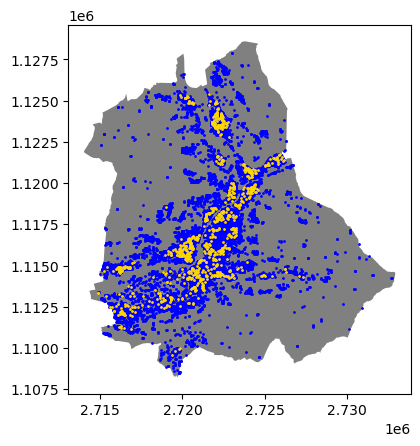

In [7]:
bldgs_in_district = bldg_geo[bldg_geo.within(district_selection.at[54,"geometry"])]
axes = district_selection.plot(facecolor="grey")
bldgs_in_district.plot(ax=axes, color="blue",markersize=1)
PV_plants_in_district.plot(ax=axes, color="gold",markersize=1)

### plot SFH, DFH, and MFH within district

<AxesSubplot: >

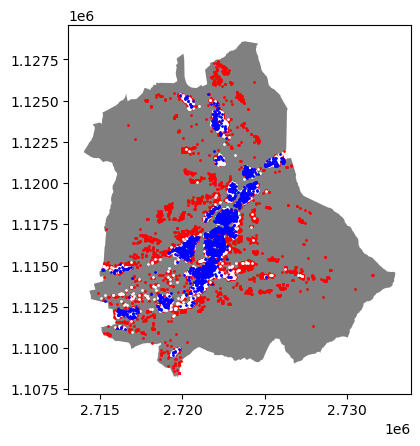

In [23]:
axes = district_selection.plot(facecolor="grey")
bldg_district_SFH.plot(ax=axes, color="red",markersize=1)
bldg_district_DFH.plot(ax=axes, color="white",markersize=1)
bldg_district_MFH.plot(ax=axes, color="blue",markersize=1)